<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork821-2023-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Gaussian Mixture Models**


Estimated time needed: **45** minutes


## Use cases of GMM:

- **Recommender systems** that make recommendations to users based on preferences (such as Netflix viewing patterns) of similar users (such as neighbors).
- **Anomaly detection** that identifies rare items, events or observations which deviate significantly from the majority of the data and do not conform to a well defined notion of normal behavior.
- **Customer segmentation** that aims at separating customers into multiple clusters, and devise targeted marketing strategy based on each cluster's characteristics.


## When is GMM better than K-Means?

Imagine you are a Data Scientist who builds a recommender for selling cars using K-Means clustering and you have two clusters. Everybody in cluster A is recommended to buy car A, which costs **100k** with a **25k** profit margin, and everyone in cluster B is recommended to buy car B, which costs **50k** with a **10k** profit margin.

Let's say you want to get as many people in cluster A as possible, why not use an algorithm that informs you of exactly how likely somebody would be interested in purchasing car A, instead of one that only tells you a hard yes or no (This is what K-Means does!). 

With GMM, not only will you be getting the predicted cluster labels, the algorithm will also give you the probability of a data point belonging to a cluster. How amazing is that! 

Whoever, is selling those cars should definitely work on a better plan for a customer with a 90% chance of purchasing, than for someone with a 75% chance of purchasing, even though they might show up in the same cluster.


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%201/images/car.png" style="width: 60%">


In this lab, you will be applying clustering analysis on multivariate datasets using **Gaussian Mixture Models** (GMM).


----


## Setup


For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for managing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and machine-learning-pipeline related functions.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Installing Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run this notebook commands in a different Jupyter environment (e.g. Watson Studio or Ananconda), you will need to install these libraries by removing the `#` sign before `!mamba` in the code cell below.


In [1]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1 wget
# Note: If your environment doesn't support "!mamba install", use "!pip install pandas==1.3.4 ..."

The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:


### Importing Required Libraries

_We recommend you import all required libraries in one place (here):_


In [2]:
# You can also use this section to suppress warnings generated by your code:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.mixture import GaussianMixture
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from itertools import chain
from matplotlib.patches import Ellipse


sns.set_context('notebook')
sns.set_style('white')

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

### Defining Helper Functions

_Use this section to define any helper functions to help the notebook's code readability:_


In [9]:
# This function will allow us to easily plot data taking in x values, y values, and a title
def plot_univariate_mixture(means, stds, weights, N = 10000, seed=10):
    
    """
    returns the simulated 1d dataset X, a figure, and the figure's ax
    
    """
    np.random.seed(seed)
    if not len(means)==len(stds)==len(weights):
        raise Exception("Length of mean, std, and weights don't match.") 
    K = len(means)
    
    mixture_idx = np.random.choice(K, size=N, replace=True, p=weights)
    # generate N possible values of the mixture
    X = np.fromiter((ss.norm.rvs(loc=means[i], scale=stds[i]) for i in mixture_idx), dtype=np.float64)
      
    # generate values on the x axis of the plot
    xs = np.linspace(X.min(), X.max(), 300)
    ps = np.zeros_like(xs)
    
    for mu, s, w in zip(means, stds, weights):
        ps += ss.norm.pdf(xs, loc=mu, scale=s) * w
    
    fig, ax = plt.subplots()
    ax.plot(xs, ps, label='pdf of the Gaussian mixture')
    ax.set_xlabel("X", fontsize=15)
    ax.set_ylabel("P", fontsize=15)
    ax.set_title("Univariate Gaussian mixture", fontsize=15)
    #plt.show()
    
    return X.reshape(-1,1), fig, ax
    
    
def plot_bivariate_mixture(means, covs, weights, N = 10000, seed=10):
    
    """
    returns the simulated 2d dataset X and a scatter plot is shown
    
    """
    np.random.seed(seed)
    if not len(mean)==len(covs)==len(weights):
        raise Exception("Length of mean, std, and weights don't match.") 
    K = len(means)
    M = len(means[0])
    
    mixture_idx = np.random.choice(K, size=N, replace=True, p=weights)
    
    # generate N possible values of the mixture
    X = np.fromiter(chain.from_iterable(multivariate_normal.rvs(mean=means[i], cov=covs[i]) for i in mixture_idx), 
                dtype=float)
    X.shape = N, M
    
    xs1 = X[:,0] 
    xs2 = X[:,1]
    
    plt.scatter(xs1, xs2, label="data")
    
    L = len(means)
    for l, pair in enumerate(means):
        plt.scatter(pair[0], pair[1], color='red')
        if l == L-1:
            break
    plt.scatter(pair[0], pair[1], color='red', label="mean")
    
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Scatter plot of the bivariate Gaussian mixture")
    plt.legend()
    plt.show()
    
    return X


def draw_ellipse(position, covariance, ax=None, **kwargs):
    
    """
    Draw an ellipse with a given position and covariance
    
    """
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))
        
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)


## What are Gaussian Mixture Models (GMM)?

Put simply, Gaussian Mixture Models (GMM) is a clustering algorithm that:

- Fits a weighted combination of Gaussian distributions to your data
- The data scientist (you) needs to determine the number of gaussian distributions (`k`)


<p style='color: blue'>Hard vs Soft Clustering:</p>

- __Hard clustering__ algorithms assign each data point to exactly one cluster.
- __Soft clustering__ algorithms return probabilities of each data point belonging to all `k` clusters

_GMM is a soft clustering algorithm._


### Background


A Gaussian mixture is a weighted combination of (`k`) Gaussians, where each is identified by the following parameters:

 1. a mean vector $\boldsymbol{\mu}_i$
 2. a covariance matrix $\boldsymbol{\Sigma}_i$
 3. a component weight $\pi_i$ that indicates the contribution of the $i$th Gaussian

When put altogether, the pdf of the mixture model is formulated as:

$$
p(\boldsymbol{x}) = \sum_{i=1}^K\pi_i \mathcal{N}(x|\boldsymbol{\mu_i,\Sigma_i}), \\\\ \sum_{i=1}^K\pi_i = 1
$$

Before we start applying the model in a multivariate setting, let's delve into the three parameters and see how changing the parameter values affect the appearance of the Gaussian mixture in a lower dimension.

_We will use the helper function **plot_univariate_mixture** to plot the mixture efficiently._


### Playing around with means, standard deviations, and weights

Let's start with a mixture of 3 univariate Gaussians with 
- means equal to **2, 5, 8** respectively
- std equal to **0.2, 0.5, 0.8** respectively
- component weight equal to **0.3, 0.3, 0.4** respectively


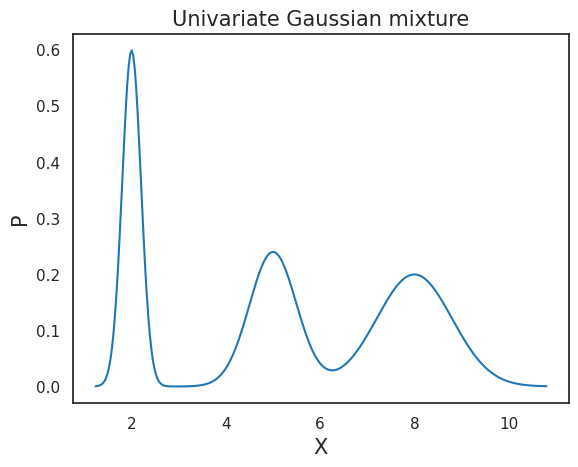

In [4]:
X1, fig1, ax1 = plot_univariate_mixture(means=[2,5,8], stds=[0.2, 0.5, 0.8], weights=[0.3, 0.3, 0.4]) 

The peaks in the distribution (pdf) plot above are around the x = 2, 5, 8, which are the means of our Gaussians. 

If we increase the value of the standard deviations, we will see the bell shapes become wider and there will be overlaps between two Gaussians.


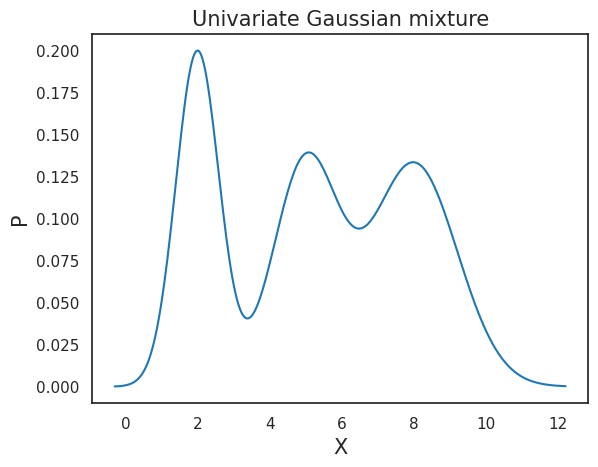

In [5]:
X2, fig2, ax2 = plot_univariate_mixture(means=[2,5,8], stds=[0.6, 0.9, 1.2], weights=[0.3, 0.3, 0.4]) 

Keeping the means and standard deviations unchanged, let's change the weights of the Gaussians and see how it affects the mixture's distribution.


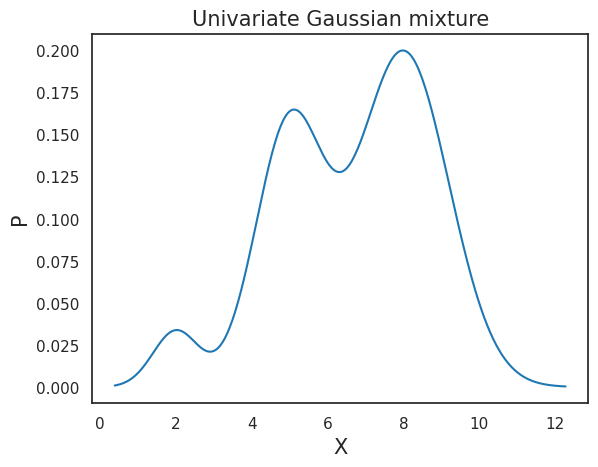

In [6]:
X3, fig3, ax3 = plot_univariate_mixture(means=[2,5,8], stds=[0.6, 0.9, 1.2], weights=[0.05, 0.35, 0.6]) 

When the weight of one Gaussian is reduced or increased, the likelihood of seeing a point from that Gaussian also decreases or increases, as illustrated in the distribution plot above.

Hence, in conclusion, the **means** determine the centers of the mixed Gaussians; the **covariance** matrices determine the width and shape of the mixed Gaussians; the **weights** determine the contributions of the Gaussians to the Gaussian mixture.


### Introducing sklearn.mixture.GaussianMixture


With generated Gaussian mixture data, we know in advance the parameter values of the individual Gaussians. When we encounter a real-world dataset, how do we know the number of Gaussians to be included in the mixture model and their corresponding parameter values?

We can utilize the **GaussianMixture** class from **Scikit-learn**. This class allows us to estimate the parameters of a Gaussian mixture distribution.

A **GaussianMixture.fit** method is provided that learns a Gaussian Mixture Model from training data. Given test data, it can assign to each sample the Gaussian it mostly probably belong to using the **GaussianMixture.predict** method.

To solve for the parameters of GMM, the **EM algorithm** is implemented. **E** stands for **Expectation** and **M** stands for **Maximization**. The algorithm works by alternating between an **E** step, which calculates the expectation of the log-likelihood of observing the dataset using the current parameter estimates, and a **M** step, which seeks new parameters estimates that maximize the expectation found in the previous E step. This process is repeated  until convergence.

For more detailed information on the **EM algorithm**, please see the page:<a href="https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork821-2023-01-01"> EM-link</a> 


### GMM.predict_proba


One parameter you must specify when implementing a GMM is `n_components`, which tells the algorithm how many clusters to look for in the dataset. Another parameter you should consider is `covariance_type`, which we will talk about later with a multivariate dataset.

Starting with **X1**, the univariate dataset we generated before using **plot_univariate_mixture**, we can fit a GMM to it with `n_components = 3` and plot the predicted prior probabilities of each point belonging to the 3 clusters. **GMM.predict_proba_** evaluates the components' density for each sample or for sample $x_n$ the probability  $p(i|x_{n})$


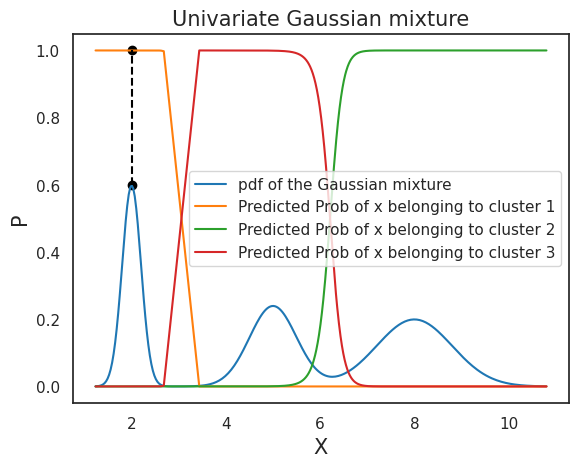

In [7]:
# sort X1 in ascending order for plotting purpose
X1_sorted = np.sort(X1.reshape(-1)).reshape(-1,1)

# fit the GMM
GMM = GaussianMixture(n_components=3, random_state=10)
GMM.fit(X1_sorted)

# store the predicted probabilities in prob_X1
prob_X1 = GMM.predict_proba(X1_sorted)

# start plotting! 
ax1.plot(X1_sorted, prob_X1[:,0], label='Predicted Prob of x belonging to cluster 1')
ax1.plot(X1_sorted, prob_X1[:,1], label='Predicted Prob of x belonging to cluster 2')
ax1.plot(X1_sorted, prob_X1[:,2], label='Predicted Prob of x belonging to cluster 3')
ax1.scatter(2, 0.6, color='black')
ax1.scatter(2, 1.0, color='black')
ax1.plot([2, 2], [0.6, 1.0],'--', color='black')
ax1.legend()
fig1

To interpret the predicted probabilities, let's take a look at the point colored in black, as an example. On the Gaussian mixture pdf, the point is at the the peak of the first bell-shaped curve. Its corresponding probability of belonging to cluster 1 is equal to 1, which demonstrates that the probability of the center of a Gaussian distribution belonging to its own cluster is 100%. 


## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
        </ol>
    </li>
    <li>
        <a href="#What-are-Gaussian-Mixture-Models (GMM)?">What are Gaussian Mixture Models (GMM)?</a>
        <ol>
            <li><a href="#Background">Background</a></li>
            <li><a href="#Playing around with means, standard deviations, and weights">Playing around with means, standard deviations, and weights</a></li>
            <li><a href="#Introducing sklearn.mixture.GaussianMixture">Introducing sklearn.mixture.GaussianMixture</a></li>
            <li><a href="#GMM.predict_proba">GMM.predict_proba</a></li>
        </ol>
    </li>
    <li>
        <a href="#Example 1: Applying GMM on a 2d dataset">Example 1: Applying GMM on a 2d dataset</a>
        <ol>
            <li><a href="#Generate an artificial 2d Gaussian mixture data">Generate an artificial 2d Gaussian mixture data</a></li>
            <li><a href="#Fit a GMM">Fit a GMM</a></li>
            <li><a href="#Plot the clusters">Plot the clusters</a></li>
            <li><a href="#Try different values of Covariance_type">Try different values of Covariance_type</a></li>          
        </ol>   
    </li>
    <li>
        <a href="#Example 2: Applying GMM on real world data - Image Segmentation">Example 2: Applying GMM on real world data - Image Segmentation</a>
    </li>
</ol>

<a href="#Exercises">Exercises</a>
<ol>
    <li><a href="#Exercise 1 - Scale the data (using StandardScaler)">Exercise 1 - Scale the data (using StandardScaler)</a></li>
    <li><a href="#Exercise 2 - Use PCA with n_components=2 for dimension reduction">Exercise 2 - Use PCA with n_components=2 for dimension reduction</a></li>
    <li><a href="#Exercise 3 - Fit a GMM to the reduced data ">Exercise 3 - Fit a GMM to the reduced data</a></li>
    <li><a href="#Exercise 4 - Output the predicted labels for visualizing clusters">Exercise 4 - Output the predicted labels for visualizing clusters</a></li>
    <li><a href="#Exercise 5 - Clustering and visualizing using 3 principal components (OPTIONAL)">Exercise 5 - Clustering and visualizing using 3 principal components (OPTIONAL)</a></li>
</ol>

## Objectives

After completing this lab you will be able to:

- __Understand__ what Gaussian mixture is and how its distribution parameters affect the prior probabilities.
- __Understand__ what Gaussian mixture model is and how it works as a clustering technique.
- __Apply__ GMM effectively.


## Example 1: Applying GMM on a 2d dataset


### Generate an artificial 2d Gaussian mixture data


We will use the helper function **plot_bivariate_mixture** to first generate a 2d Gaussian mixture dataset, and then visualize the data points.


In [11]:
# setting parameter values for the Gaussian mixture data
# we include three Gaussians in this example

mean = [(1,5), (2,1), (6,2)]
cov1 = np.array([[0.5, 1.0],[1.0, 0.8]])
cov2 = np.array([[0.8, 0.4],[0.4, 1.2]])
cov3 = np.array([[1.2, 1.3],[1.3, 0.9]])
cov = [cov1, cov2, cov3]
weights = [0.3, 0.3, 0.4]

X4 = plot_bivariate_mixture(means=mean, covs=cov, weights=weights, N=1000)                    

ValueError: ignored

To work with GMM, we can use the **GaussianMixture** function from **sklearn.mixture**. The function will fit a GMM to our data and return the clustering result which includes the parameter values we discussed.


In [14]:
print("The dataset we generated has a shape of", X4.shape)

NameError: ignored

### Fit a GMM


In [ ]:
# since we generated a mixture dataset X4 with 3 Gaussians, it makes sense to set n_components = 3.
gm = GaussianMixture(n_components=3, random_state=0).fit(X4)
print("Means of the 3 Gaussians fitted by GMM are\n")
print(gm.means_)

In [ ]:
print("Covariances of the 3 Gaussians fitted by GMM are")
gm.covariances_

The 3 centers returned by our fitted GMM are all very close to the means we set for generating the mixture data, which means the model fitting was quite successful. 

We can also draw the 3 ellipses, using the fitted parameter values, to check if they indeed represent the 3 clusters from our generated data.


### Plot the clusters


We will use the helper functions **draw_ellipse** and **plot_gmm** to plot the original scatter plot as well as the clusters produced by a fitted GMM.


In [ ]:
plot_gmm(GaussianMixture(n_components=3, random_state=0), # the model, 
          X4) # simulated Gaussian mixture data

### Try different values of Covariance_type


For the **sklearn.mixture.GaussianMixture** function, not only can we specify the number of clusters we want the GMM to fit, we can also specify the type of covariance parameters to use (recall we discussed that **covariance** matrices determine the shapes of our Gaussians. Depending on the dataset (different datasets have different Gaussian mixture structures), there are 4 values you can try for **Covariance_type**:

- `full` each component has its own general covariance matrix.
- `tied` all components share the same general covariance matrix.
- `diag` each component has its own diagonal covariance matrix.
- `spherical` each component has its own single variance.

_The default **Covariance_type** in **sklearn.mixture.GaussianMixture** is `full`._

**Sometimes you can't use covariance_type = full, because you can't invert it and this will give you an error.**


In [29]:
# try Covariance_type = 'tied'
plot_gmm(GaussianMixture(n_components=3, covariance_type='tied',random_state=0), # the model, 
         X4)

NameError: ignored

In [ ]:
# try Covariance_type = 'diag'
plot_gmm(GaussianMixture(n_components=3, covariance_type='diag',random_state=0), # the model, 
         X4)

It is clear visually that **covariance_type =** `full` is a good choice for the generated data. This makes sense because we did intentionally make each Gaussian have its own covariance matrix.

Now we know how to work with GMM in a lower dimension (2d), we can import a real-world dataset and use GMM to perform a clustering analysis on it.


## Example 2: Applying GMM on real world data - Image Segmentation


Image segmentation is the process of segmenting an image into multiple important regions.

We can use a GMM to segment an image into **K** regions `(n_components = K)` according to significant colors.

Each pixel would be a data point with three features (r, g, b), or one feature, if greyscale. 

For instance, if we are working with a 256 $\times$ 256 image, you would have 65536 pixels in total and your data $X$ would have a shape of 65536 $\times$ 3.

Let's look at an example using a picture of a house cat:

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%201/images/gauss-cat.jpeg" style="width: 50%">


Let's download the image: 


In [15]:
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%201/images/gauss-cat.jpeg

--2023-05-02 22:35:06--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%201/images/gauss-cat.jpeg
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983483 (960K) [image/jpeg]
Saving to: ‘gauss-cat.jpeg’

gauss-cat.jpeg      100%[===================>] 960.43K  1.01MB/s    in 0.9s    

2023-05-02 22:35:07 (1.01 MB/s) - ‘gauss-cat.jpeg’ saved [983483/983483]



First, let's segment our image using 2 gaussian distributions:


In [16]:
img = plt.imread('gauss-cat.jpeg')

# If img is greyscale, then change to .reshape(-1, 1):
X = img.reshape(-1, 3)
# The number of components; you can change this to a positive integer of your choice!:
n = 2
gmm = GaussianMixture(n_components=n, covariance_type='tied')
gmm.fit(X)
labels = gmm.predict(X) # num of pixels x 1

Now, we replace each pixel with the "average color" or the mean RGB values of the gaussian distribution it belongs to:


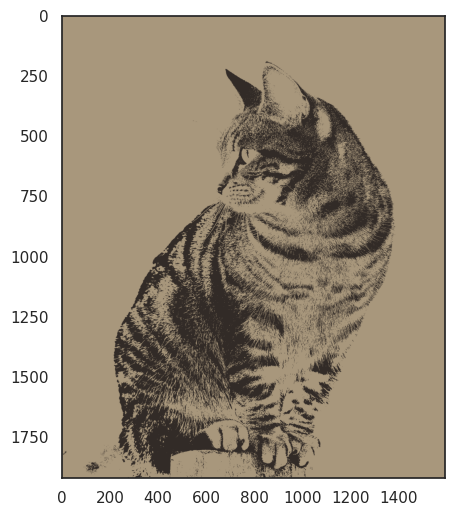

In [17]:
seg = np.zeros(X.shape) # num of pixels x 3

for label in range(n):
    seg[labels == label] = gmm.means_[label]
seg = seg.reshape(img.shape).astype(np.uint8)

plt.figure(figsize=(6,6))
plt.imshow(seg)

Similarly, if we increase the number of components to 8:


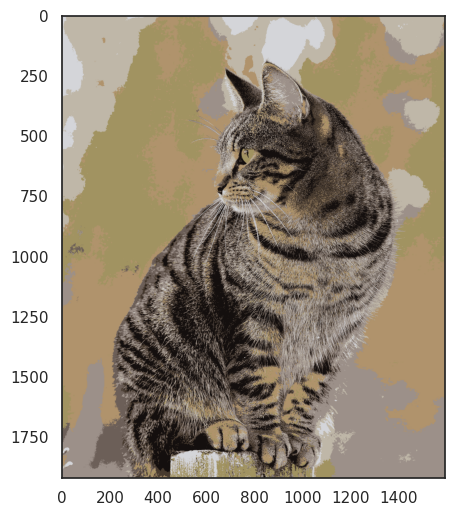

In [18]:
n = 8
gmm = GaussianMixture(n_components=n, covariance_type='tied')
gmm.fit(X)
labels = gmm.predict(X) # num of pixels x 1
seg = np.zeros(X.shape) # num of pixels x 3

for label in range(n):
    seg[labels == label] = gmm.means_[label]
seg = seg.reshape(img.shape).astype(np.uint8)
#cv2.imwrite(f'gauss-cat-{n}.jpeg', seg)

plt.figure(figsize=(6,6))
plt.imshow(seg)
plt.show()

Our segmented image looks remarkably similar to the original, even though it uses only 8 colors!


# Exercises


For the exercises, we will use the Customer Personality Analysis dataset ([marketing_campaign.csv](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork821-2023-01-01)) from Kaggle, provided by Dr. Omar Romero-Hernandez. Several preprocessing steps were taken, including but not limited to, impute missing values, feature engineering, and feature encoding.

The preprocessed customers dataset contains 19 attributes on the customers' purchasing behaviors, education, income, marital status, etc. You will be able to practice principal component analysis, and apply GMM on the dataset for the purpose of customer segmentation.


First we load data into a `pandas.DataFrame`:


In [19]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%201/customers.csv")
data.head()

# you can also download the csv file to your local workspace using:
# ! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML0187EN-SkillsNetwork/labs/module%201/customers.csv

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Spent,Living_Status,Children
0,0,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,1617,0,0
1,0,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,27,0,2
2,0,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,776,1,0
3,0,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,53,1,1
4,1,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,422,1,1


In [20]:
data.shape

(2216, 19)

### Exercise 1 - Scale the data (using StandardScaler)


In [22]:
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
X = SS.fit(data).transform(data)

<details>
    <summary>Click here for Solution</summary>

```python
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
X = SS.fit(data).transform(data)
```

</details>


### Exercise 2 - Use PCA with n_components = 2 for dimension reduction


In [23]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
reduced_2_PCA = pca2.fit(X).transform(X)

<details>
    <summary>Click here for Solution</summary>

```python
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
reduced_2_PCA = pca2.fit(X).transform(X)
```

</details>


### Exercise 3 - Fit a GMM to the reduced data


In [24]:
model = GaussianMixture(n_components=4, random_state=0)
model.fit(reduced_2_PCA)

GaussianMixture(n_components=4, random_state=0)

<details>
    <summary>Click here for Solution</summary>

```python
model = GaussianMixture(n_components=4, random_state=0)
model.fit(reduced_2_PCA)
```

</details>


### Exercise 4 - Output the predicted labels for visualizing clusters


In [25]:
PCA_2_pred = model.predict(reduced_2_PCA)

<details>
    <summary>Click here for Solution</summary>

```python
PCA_2_pred = model.predict(reduced_2_PCA)
```

</details>


Now you can plot the clusters in 2d using 2 principal components, colored by predicted labels.


Text(0, 0.5, 'PCA 2')

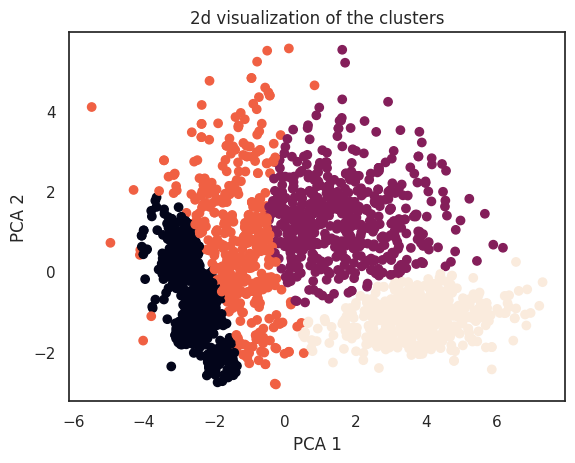

In [26]:
x = reduced_2_PCA[:,0]
y = reduced_2_PCA[:,1]
plt.scatter(x, y, c=PCA_2_pred)
plt.title("2d visualization of the clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

<details>
    <summary>Click here for Solution</summary>

```python
x = reduced_2_PCA[:,0]
y = reduced_2_PCA[:,1]
plt.scatter(x, y, c=PCA_2_pred)
plt.title("2d visualization of the clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
```

</details>


### Exercise 5 - Clustering and visualizing using 3 principal components (OPTIONAL) 


Text(0.5, 0.92, '3D projection of the clusters')

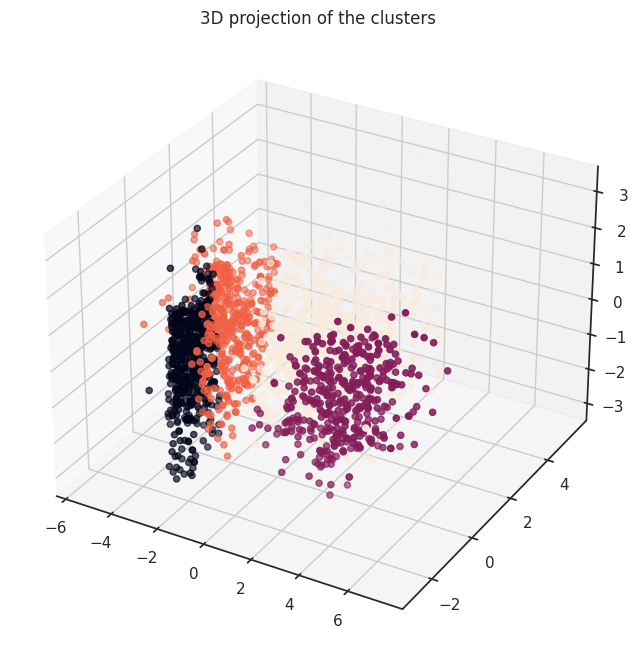

In [28]:
# PCA with n=3 and clustering
pca3 = PCA(n_components=3)
reduced_3_PCA = pca3.fit(X).transform(X)
mod = GaussianMixture(n_components=4, random_state=0)
PCA_3_pred = mod.fit(reduced_3_PCA).predict(reduced_3_PCA)

# plotting
reduced_3_PCA = pd.DataFrame(reduced_3_PCA, columns=(['PCA 1', 'PCA 2', 'PCA 3']))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(reduced_3_PCA['PCA 1'],reduced_3_PCA['PCA 2'],reduced_3_PCA['PCA 3'], c=PCA_3_pred)
ax.set_title("3D projection of the clusters")

<details>
    <summary>Click here for Solution</summary>

```python
# PCA with n=3 and clustering
pca3 = PCA(n_components=3)
reduced_3_PCA = pca3.fit(X).transform(X)
mod = GaussianMixture(n_components=4, random_state=0)
PCA_3_pred = mod.fit(reduced_3_PCA).predict(reduced_3_PCA)

# plotting
reduced_3_PCA = pd.DataFrame(reduced_3_PCA, columns=(['PCA 1', 'PCA 2', 'PCA 3']))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(reduced_3_PCA['PCA 1'],reduced_3_PCA['PCA 2'],reduced_3_PCA['PCA 3'], c=PCA_3_pred)
ax.set_title("3D projection of the clusters")
```

</details>


## Congratulations! You have completed this lab!


## Authors


[Roxanne Li](https://www.linkedin.com/in/roxanne-li/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork821-2023-01-01) is a Data Science intern at IBM Skills Network, entering level-5 study in the Mathematics & Statistics undergraduate Coop program at McMaster University.


## Change Log


|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2020-07-17|0.1|Sam|Create Lab Template|
|2022-05-16|0.1|Roxanne|Create First Draft|
|2022-07-18|0.1|Svitlana K.|Review and Edit|


Copyright © 2022 IBM Corporation. All rights reserved.
